# Unify SCME Dispersion Function

## Theory: Dispersion Energy Calculation in SCME

The dispersion contributions in SCME are calculated using a Lennard-Jones-(10, 8, 6)-potential function of the form
\begin{equation}
E_\mathrm{disp}(r) = -\frac{C_6}{r^6} - \frac{C_8}{r^8} - \frac{C_{10}}{r^{10}}
\end{equation}
where $r$ is the pair distance between water molecules, $n$ is the order, and $C_n$ are the empirical coefficients.
This LJ potential is used in combination with a Tang-Toennis damping function of the form
\begin{equation}
f_{n}(r) = 1.0 - c\ \exp{(-br)}\ \sum_{k=0}^{n}{\frac{(br)^k}{k!}}
\end{equation}
where $n$ is the order, $r$ is the damping target and $c$ and $b$ are damping coefficients. Only
the $b$ coefficient is used in the current implementation.

As can be seen from the LJ potential function, only the attractive component of the potential is calculated, the repulsive interaction (typically the $C_{12}$ component) is handled in another part of the code.

The values for the empirical coefficients used in the SCME dispersion model are:
```C
C6 = 27.75096402
C8 = 191.0346465
C10 = 1566.901564
c = 1.0
b = 7.55480010
```

## Affected File Structure in the SCME Source Code

* `./ase_interface.py`: This Python file defines the `SCME_PS` calculator class for ASE which is derived from the `ase.calculators.Calculator` blueprint parent class. The getter function `SCME_PS.scme_DS()` implements a call to `pybind_scme_qmmm.scme_disp()` in `./src/pybind_scme_qmmm.cpp` to calculate the dispersion interaction.

* `./src/pybind_scme_qmmm.cpp`: This C++ file implements the Python-C++ interface. The `pybind_scme_qmmm.scme_disp()` function takes the arguments passed from the Python `SCME_PS.scme_DS()` function and funnels them into the C++ `scme_Disp()` function in `./src/scme_qmmm.cpp`.

* `./src/scme_qmmm.cpp`: This C++ file implements a wrapper (?) function `scme_Disp()` which makes a simple calculation of halving the cell dimension array $a$ which is passed to it and passes it on to `dispersion()` in `./src/dispersion.cpp`.

* `./src/dispersion.cpp`: This C++ file implements the actual calculation of the dispersion interactions. The LJ-(10, 8, 6)-potential and Tang-Toennis damping function are separated in two functions, `dispersion()` and `Tang_Toennis()` (the latter being called from the former, and the former being called from `./src/scme_qmmm.cpp`).

## Project Milestones

1. The `SCME_PS.scme_DS()` getter function should be able to accept coordinates from either only MM or mixed QM and MM coordinate space. (FINISHED)

1. The dispersion function should make use of a smooth cutoff function which screens off dispersion energy contributions. Ideally, the function should make sure that the dispersion energy is not even calculated after a certain hard cutoff $r_c$ but smoothly screened between values $r_0$ and $r_c$. The form of the smooth screening could be adapted from `ase.calculator.LJ`. (FINISHED)

1. Introduce dependence on $N_\mathrm{c}$, the number of nearest-neighbor cells included in calculations of energy terms in QMMM calculations with 2D-periodic surface models. A similar approach as used for the electrostatic potential may be implemented here.

## Development Benchmark System

The benchmark system which will be used for milestones 1 and 2 is a water dimer where one dimer is offset by 45 °. For milestone 3, another benchmark system will be introduced to introduce 2D-periodic boudnary conditions.

```python
import numpy as np
from matplotlib import pyplot as plt
from ase.build import molecule
from ase_interface import SCME_PS

# Make H2O molecule with experimental bond lengths.
# (tag = 1)
atoms = molecule("H2O")
atoms.cell = [10, 10, 10]
atoms.pbc = False
atoms.translate([0, 0, 2.0])
atoms.rotate(90, "z")
atoms.rotate(45, "x")
atoms.set_tags(1)

# Add second water molecules. (tag = 0)
atoms += molecule("H2O")
atoms.center()

# Add SCME calculator.
atoms.calc = SCME_PS(atoms)

# Results list holds O-O distance and corresponding E_vdw.
results = []

# Vary the positions of one molecule.
mol_idx = [atom.index for atom in atoms if atom.tag == 1]
for i in range(50):

    # Adjust positions.
    pos = atoms.get_positions()
    pos[mol_idx] += [0, 0, 0.1]
    atoms.set_positions(pos)

    # Calculate O-O distance.
    d = atoms.get_distance(0, 3)
    print("\nO-O distance: ", d)

    # Make array of O atom positions.
    coords_o = np.asarray([atom.position for atom in atoms
                           if atom.symbol == "O"])

    # Calculate E_vdw.
    atoms.calc.initialize_scme()
    atoms.calc.scme_DS()
    Evdw = atoms.calc.energy_DS
    print("E_vdw = ", Evdw)

    # Log results.
    results.append((d, Evdw))

# Visualize results.
x, y = zip(*results)
plt.plot(x, y, "-")
plt.xlabel("O-O distance / A")
plt.ylabel("$E_\mathrm{vdW}$ / eV")
plt.show()
```

## Reference Output Before Changes

This output was generated on 2023/04/03 using the `cmake_elvarmakesamess` branch. This will be used as reference output for milestones 1 and 2. This output should be reproduced exactly after implementing changes in Milestone 1 and only minor changes should be introduced by the cutoff function planned for Milestone 2.

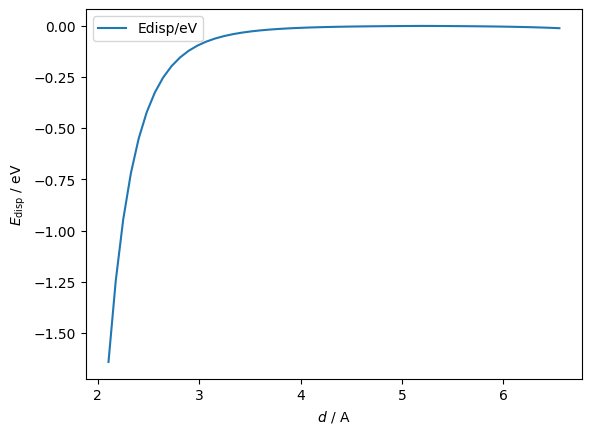

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230403_2H2O_Edisp_ref.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.show()

The dip towards more negative numbers at values of $d$ > 6 is a result of internal treatment of PBCs in SCME C++. This problem is addressed below since for molecular systems like this one, PBCs should not be taken into account.

## Milestone 1: Only-MM or Mixed QM/MM Coordinate Space (FINISHED)

For QMMM calculations, the dispersion function needs to know which molecules are QM and which are MM in order to calculate dispersion contributions for all QM-MM and MM-MM but not for QM-QM pairs. Dispersion between QM molecules is taken care of by an optional QM dispersion function such as DFT-D3 or any of the self-consistent DFT-vdW functionals.

To implement and check this information, a new `tags` array is implemented which holds the QM or MM information for each atom. We arbitrarily decide that True = QM and False = MM. 

The calculation of the pair-wise dispersion contributions is implemented as in `dispersion.cpp` as a nested double for loop. The outer loop goes over all molecules $n$, the inner loop over the remaining molecules $m = n + 1$. While the first atom $n$ can be a QM or MM atom, we check that the second atom $m$ is always MM.

The loop is implemented as:

```c++
// Loop through all water molecules until second to last.
for (int n = 1; n < nM; n++) {
    // Find index of oxygen atom 1.
    iOn = 9*(n-1);
    // Loop through all remaining water molecules starting
    // from iOn + 1 until last molecule.
    for (int m = n + 1; m < nM+1; m++) {
        // Find index of oxygen atom 2.
        if (!tags[m]) {
            [...]
        }
        [...]
    }
    [...]
}
```

For this fix to work, the `tags` array must now always be passed to `dispersion()`. If SCME is used as a standalone calculator, we therefore need to pass a placeholder array which is all False for each atom in the system.

The `scme_DS` function in `./ase_interface.py/` has therefore been adapted as follows:

```python
def scme_DS(self):

        # This function is never called from QMMM so we can
        # use hardcoded tags identifying all atoms as MM.
        tags = [False for i in self.atoms]
        tags = np.array(tags)

        energy, forces = pybind_scme_qmmm.scme_disp(self.molnum,
                                    self.coordinates,
                                    self.cell,
                                    self.pbc,
                                    self.u_DS,
                                    self.fa_DS,
                                    self.td,
                                    tags)

        self.energy_DS = energy
        self.forces_DS = forces

        print("energy DS: ",self.energy_DS)
        print("forces DS: ",self.forces_DS)
```

The tags parameter has been threaded through the innards of SCME accordingly. It is first passed to `scme_dispersion()` and `scme_Disp()` in `./src/pybind_scme_qmmm.cpp`. Then it is passed further to `scme_Disp()` and `dispersion()` in `./src/scme_qmmm.cpp` which then passes it to `dispersion.cpp`. Headers have been updated accordingly as well.

```{warning} Future ToDo: need to implement the
`tags` keyword in the ASE polarizable embedding QMMM interface!
```

## Milestone 2: Introducing a Smooth Cutoff Value (Finished)

A smooth cutoff function for the energy and forces is introduced. To this end, the following expressions used in `ase.calculators.lj` are adapted:

```python
def cutoff_function(r, rc, ro):
    """Smooth cutoff function.

    Goes from 1 to 0 between ro and rc, ensuring
    that u(r) = lj(r) * cutoff_function(r) is C^1.

    Defined as 1 below ro, 0 above rc.

    Note that r, rc, ro are all expected to be squared,
    i.e. `r = r_ij^2`, etc.

    Taken from https://github.com/google/jax-md.

    """

    return np.where(
        r < ro,
        1.0,
        np.where(r < rc, (rc - r) ** 2 * (rc + 2 * r - 3 * ro) / (rc - ro) ** 3, 0.0),
    )


def d_cutoff_function(r, rc, ro):
    """Derivative of smooth cutoff function wrt r.

    Note that `r = r_ij^2`, so for the derivative wrt to `r_ij`,
    we need to multiply `2*r_ij`. This gives rise to the factor 2
    above, the `r_ij` is cancelled out by the remaining derivative
    `d r_ij / d d_ij`, i.e. going from scalar distance to distance vector.
    """

    return np.where(
        r < ro,
        0.0,
        np.where(r < rc, 6 * (rc - r) * (ro - r) / (rc - ro) ** 3, 0.0),
    )
```

These functions are converted to C++ code in `dispersion.cpp` in the following way:

```C++ 
double cutoff_function(double r, double ro, double rc) {
    // Adapted from ase.calculators.lj.cutoff_function.
    if (r < ro) {
        return 1.0;
    } else if (r < rc) {
        double rc_r = rc - r;
        double rc_ro = rc - ro;
        double numerator = rc_r * rc_r * (rc + 2 * r - 3 * ro);
        double denominator = rc_ro * rc_ro * rc_ro;
        return numerator / denominator;
    } else {
        return 0.0;
    }
}

double d_cutoff_function(double r, double ro, double rc) {
    // Adapted from ase.calculators.lj.d_cutoff_function.
    if (r < ro) {
        return 0.0;
    } else if (r < rc) {
        double rc_ro = rc - ro;
        double numerator = 6 * (rc - r) * (ro - r);
        double denominator = rc_ro * rc_ro * rc_ro;
        return numerator / denominator;
    } else {
        return 0.0;
    }
}
```

The cutoff value $r_\mathrm{c}$ and cutoff onset value $r_\mathrm{o}$ are defined as

$r_\mathrm{c} = 3 \cdot \sigma_\mathrm{H2O} = 3 \cdot 3.1535779419765$

$r_\mathrm{o} = 0.66 * r_\mathrm{c}$.

These definitions are chosen analgous again to the ones in `ase.calculators.lj`. The $\sigma_\mathrm{H2O}$ value for TIP4P water is used: [10.1063/1.445869](https://doi.org/10.1063/1.445869).

The routines in the code are adapted so that the pair-wise energy and force terms are only evaluated if the smooth cutoff > 0 to save some CPU cycles.

Reference results from the `elvarmakesamess` branch look as follows:

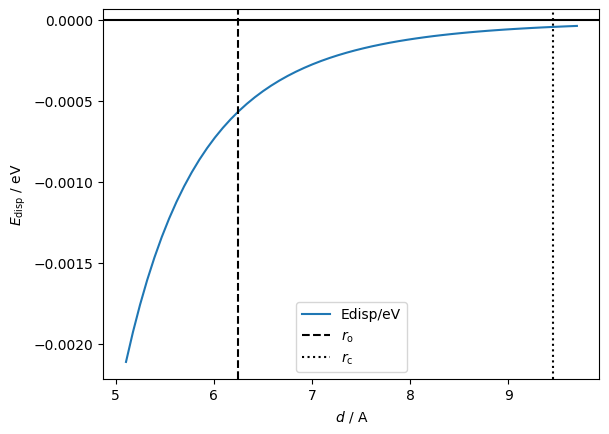

In [26]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_original.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
plt.axhline(y=0, color="black")
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

The zero line is indicated as a solid black horizontal line. The smooth cutoff onset, $r_\mathrm{o}$, and final cutoff, $r_\mathrm{c}$, which are used below, are indicated as dashed and dotted vertical black lines, respectively.

Note that this simulation used a box much larger than 10 A because the original implementation always performs PBC wrapping, which would show up as an increase in binding energy here after the $d = 5$ mark.

On the `unifydispersion` branch, using the PBC fix described below in Milestone 3, the resulting $E_\mathrm{disp}$ *vs.* $r$ plot without any cutoff value look like this:

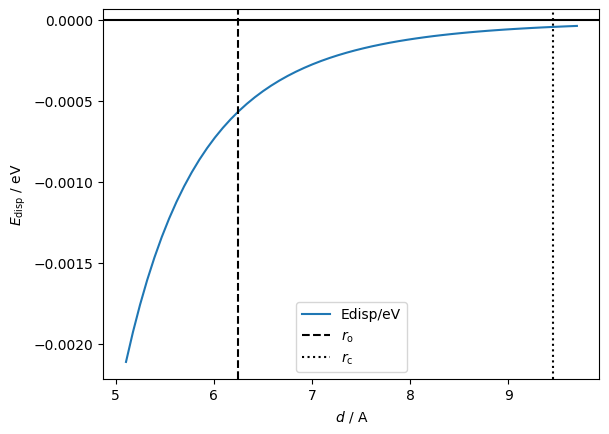

In [27]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_no_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
plt.axhline(y=0, color="black")
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

With a hard cutoff, *i.e.* with the energy and forces going to zero abrupty at $r_\mathrm{c}$, $E_\mathrm{disp}$ *vs.* $r$ results around the cutoff region are discontinuous:

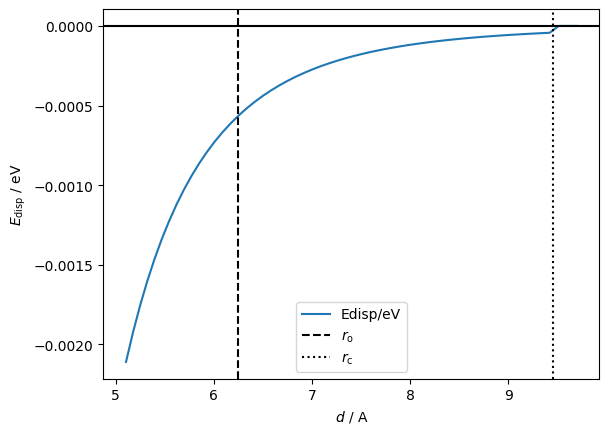

In [28]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_hard_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
plt.axhline(y=0, color="black")
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

The jump is on the order of 1e-5 eV. With the smoothing function in place, the results look like this:

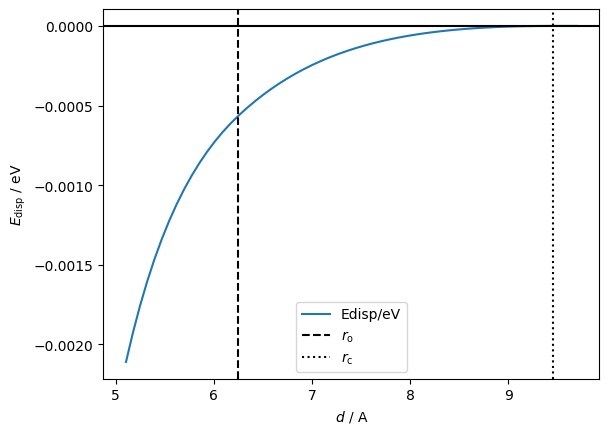

In [29]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_smooth_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
plt.axhline(y=0, color="black")
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

Reproduction of the reference output looks as follows:

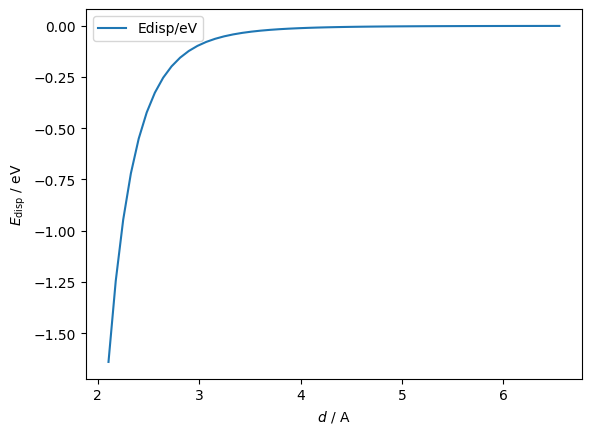

In [30]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_Edisp_smooth_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.show()

The reference data is reproduced, except for the dip for $d$ > 6 A since this plot was generated after the PBC treatment had already been fixed (Milestone 3).

Introducing the smooth cutoff for the energy is straight forward but introducing it for the forces is more tricky since the calculation in `ase.calculators.lj` is done fundamentally different.

Here is the force plot for the same benchmark region using the `cmake_elvarmakesamess` branch before any cutoff was introduced:

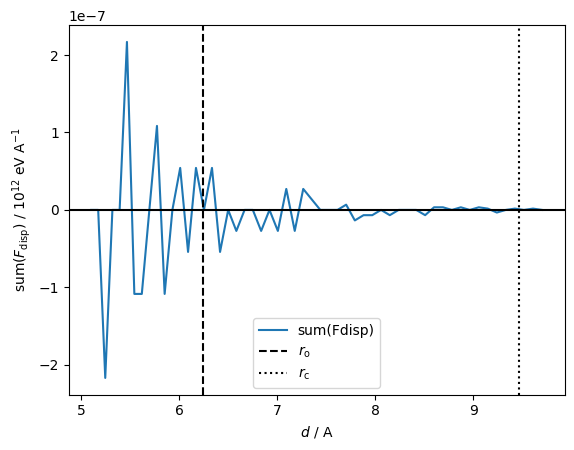

In [31]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_original.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
plt.axhline(y=0, color="black")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / 10$^{12}$ eV A$^{-1}$")
plt.legend()
plt.show()

Using the `unifydispersion` branch, we first test without any cutoffs (smoothing function disabled). The critical distance $r_\mathrm{c}$ is at *ca.* 9.45 A.

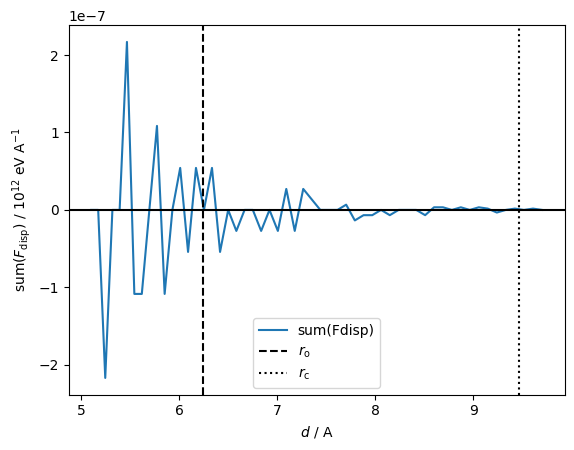

In [32]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_no_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
plt.axhline(y=0, color="black")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / 10$^{12}$ eV A$^{-1}$")
plt.legend()
plt.show()

Same as before - good. Next, hard cutoff.

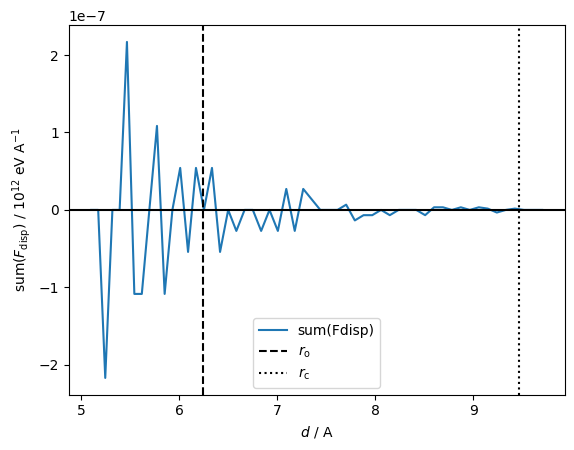

In [33]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_hard_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
plt.axhline(y=0, color="black")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / 10$^{12}$ eV A$^{-1}$")
plt.legend()
plt.show()

Next, smooth cutoff.

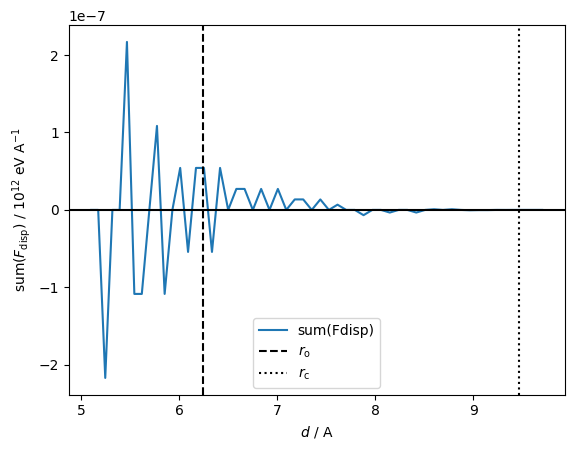

In [34]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230405_2H2O_forces_smooth_cutoff.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
plt.axhline(y=0, color="black")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / 10$^{12}$ eV A$^{-1}$")
plt.legend()
plt.show()

The energy contributions here are very, very small (because only a dimer is involved) but still, the smooth cutoff function helps bring them to zero in a steady way.

## Milestone 3: Dependence on $N_\mathrm{c}$

### ToDo List
- [x] Thread `atoms.pbc` through into `dispersion.cpp`.
- [x] Modify behavior of `dispersion()` to respect the actual periodic boundaries.
- [ ] Introduce switch to explicitly take into account (and not PBC-correct!) coordinates of atoms in $N_\mathrm{c}$ number of nearest-neighbor cells.
- [ ] Adapt loop from electrostatic interaction potential to calculate $E_\mathrm{disp}$ as a function of $N_\mathrm{c}$ number of nearest-neighbor cells.

### Problem with PBCs

Currently the dispersion code shows inconsistent behavior wrt. PBCs. When mapping the dispersion energy between two water molecules, there are minima at distance $d = 0$ and $d = \mathrm{boxsize}$ (in this case 10 A), see example:

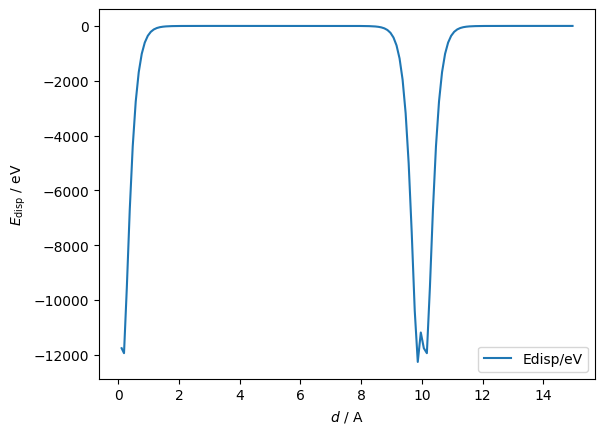

In [35]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230403_2H2O_Edisp_pbc_weirdness.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.show()

This behavior is caused by a piece of code in `./src/dispersion.cpp` which always enforces PBCs as long as molecules remain within the dimensions $a$ of the simulation cell. The corrected, internally used distance $r$ is:

$r = d$ if $d <= \frac{a}{2}$

$r = a - d$ if $d > \frac{a}{2}$

but then no check exists that translates $r$ internally if $d > a$, *i.e.*

$ r = d - a$ if $d > a$.

The code in question is the following:

```C++
for (int i = 0; i < 3; i++) {
    dr[i] = ra[iOm + i] - ra[iOn + i];
    if (dr[i] > a2[i]){
        dr[i] -= a[i];
    }
    else if (dr[i] < -a2[i]){
        dr[i] += a[i];
    }
}
```

This code needs to be adapted so that it

1. also correctly translates molecules which have escaped the original simulation cell and

2. only performs the PBC fix for dimensions which are actually periodic.

### PBC fix

The issue with periodic boundary conditions is now fixed. 

Firstly, the PBC translation as shown in the code above is now ignored if the dimension in question is non-periodic.

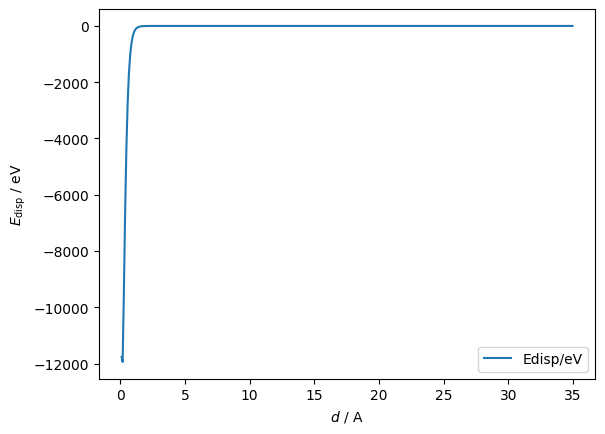

In [36]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230404_2H2O_Edisp_no_pbc_fix.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.show()

However, if PBCs are present, the PBC wrapping is repeated as many times as needed to translate the molecule back into the original cell.

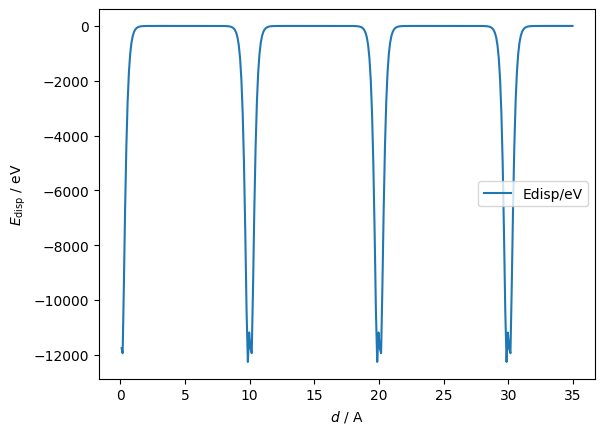

In [37]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230404_2H2O_Edisp_pbc_fix.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.show()

In order to control this behavior, the numpy boolean `ase.Atoms.pbc` array needed to be threaded through to `dispersion.cpp`. The following updated code excerpt from above shows how both problems where solved by introducing a check for `ase.Atoms.pbc` and use of a multiplier to translate coordinates.

```C++
for (int i = 0; i < 3; i++) {
    dr[i] = ra[iOm + i] - ra[iOn + i];
    if (pbc[i] == 1) {
        multi = static_cast<int>(dr[i] / a[i]);
        if (abs(dr[i]) > a2[i]){
            dr[i] -= multi * a[i];
        }
    }
}
```

The multiplier will be positive or negative depending on if dr < a or dr > a. Hence, no need anymore for the `if` check in the previous iteration.

UPDATE: after implementing this type of PBC check in `coreInt.cpp` for the nuclear repulsion term, I noticed that this routine isn't always consistent. It is now updated to:

```C++
for (int j = 0; j < 3; j++) {
    dr[j] = ra[iOm + j] - ra[iOn + j];
    if (pbc[j]) {
        // Correct distance for periodic boundary conditions.
        dr[j] = fabs(dr[j]);
        dr[j] -= static_cast<int>(dr[j] * inv_a[j] +  0.5) * a[j];

        // Periodic repetition based on Nc.
        dr[j] += NcList[i][j] * a[j];
    }
}
```

### Implementing dependence on $N_\mathrm{c}$

To implement the dependence on $N_\mathrm{c}$, which is the number of cell repetitions taken into account to evaluate the interactions in system with 2D-periodic boundary conditions, the $N_\mathrm{c}$ parameter was first funneled through the innards of SCME into `dispersion.cpp` in a similar fashion as described above for the PBC and tags arrays.

```{info} I made the decision that pre-filtering of 
$N_\mathrm{c}$ based on the cutoff would not happen inside specific functions like dispersion but
would happen at the top level before $N\mathrm{c}$ is passed into SCME.
```

Next, the loop over $N_\mathrm{c}$ was implemented similar to `./src/calc_higher_order.cpp`, with the difference being that in case of `dispersion.cpp` the nested loops are of the form

```c++
for (int n = 1; n < nM; n++) {
    for (int m = n + 1; m < nM+1; m++) {
        [...]
    }
    [...]
}
```

and `calc_higher_order.cpp` implements them as

```c++
for (int i = 0; i < nM; i++) {
    for (int j = 0; j < nM; j++) {
        [...]
    }
    [...]
}
```

In other words, the second example evaluates both $i-j$ and $j-i$ pairs while the first avoids double counting.

First, a safety check is implemented which makes sure that only the original cell and no repetitions are evaluated along non-periodic directions, even if $N_\mathrm{c} > 0$ is supplied for that direction:
```c++
// Nc must be ignored along non-periodic dimensions.
// Overwrite for safety.
for (int i = 0; i < 3; i++) {
    if (!pbc[i] && Nc[i] > 0) {
        Nc[i] = 0;
    }
}
```

Next, the main evaluation loop is extended by another 3 levels of nested for loops which cover all permutations of $N_\mathrm{c}$. For example, let [0,0,0] indicate the original simulation cell. If $N_\mathrm{c} = [1,1,0]$ is supplied, the code must calculate distances between all molecules in the original cell and molecules in the following cells: 

[-1,&nbsp;-1,&nbsp;0], [-1,&nbsp;0,&nbsp;0], [-1,&nbsp;1,&nbsp;0],<br>
[&nbsp;0,&nbsp;-1,&nbsp;0], [&nbsp;0,&nbsp;0,&nbsp;0], [&nbsp;0,&nbsp;1,&nbsp;0],<br>
[&nbsp;1,&nbsp;-1,&nbsp;0], [&nbsp;1,&nbsp;0,&nbsp;0], [&nbsp;1,&nbsp;1,&nbsp;0]

This code extends the main loop shown above in the other milestones and looks as follows:

```c++
// Evaluate periodic repetitions (depending on Nc).
for (int nx = -Nc[0]; nx < Nc[0]+1; nx++) {
    for (int ny = -Nc[1]; ny < Nc[1]+1; ny++) {
        for (int nz = -Nc[2]; nz < Nc[2]+1; nz++) {
            int nArray [3] = {nx, ny, nz};
            // Loop through all water molecules until second to last.
            for (int n = 1; n < nM; n++) {
                // Find index of oxygen atom 1.
                iOn = 9*(n-1);
                // Loop through all remaining water molecules starting
                // from iOn + 1 until last molecule.
                for (int m = n + 1; m < nM+1; m++) {
                    // Find index of oxygen atom 2.
                    if (!tags[m]) {
                        iOm = 9*(m-1);
                        // Calculate coordinate difference.
                        for (int i = 0; i < 3; i++) {
                            dr[i] = ra[iOm + i] - ra[iOn + i];
                            // Correct distance for periodic boundary conditions.
                            if (pbc[i] == 1) {
                                multi = static_cast<int>(dr[i] / a[i]);
                                if (abs(dr[i]) > a2[i]){
                                    dr[i] -= multi * a[i];
                                }
                                // Periodic repetition.
                                dr[i] += nArray[i] * a[i];
                            }
                        }

                        // Calculate distance.
                        r2 = dr[0]*dr[0] + dr[1]*dr[1] + dr[2]*dr[2];
                        r = sqrt(r2);

                        // No energy / forces evaluated outside cutoff distance.
                        if (r2 < rc2) {
                            [... Energy and force evaluation is unchanged ...]
                        }
                    }
                }
            }
        }
    }
}
```

The following plots validate that results for the water dimer have not changed due to this new code structure when PBCs are turned off:

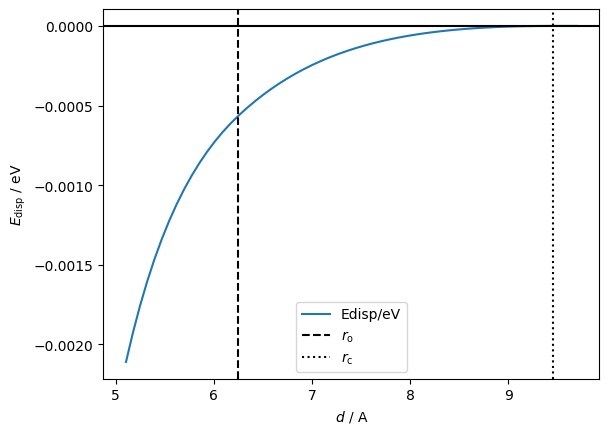

In [38]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_false.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
plt.axhline(y=0, color="black")
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

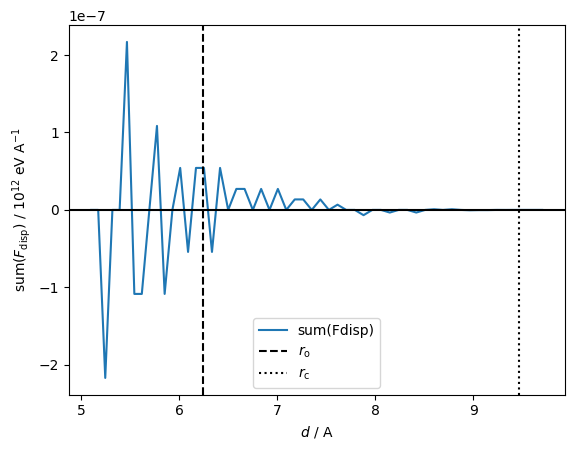

In [39]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_false.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
plt.axhline(y=0, color="black")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / 10$^{12}$ eV A$^{-1}$")
plt.legend()
plt.show()

The next set of plots validate that results have also not changed if PBCs are True in all cases and $N_\mathrm{c} = [10,10,10]$ is set (with $a$ = 10 A, the box is larger than $r_\mathrm{c}$ at *ca.* 9.45 A (see above) and evaluating periodic repetitions therefore SHOULD NOT change the results):

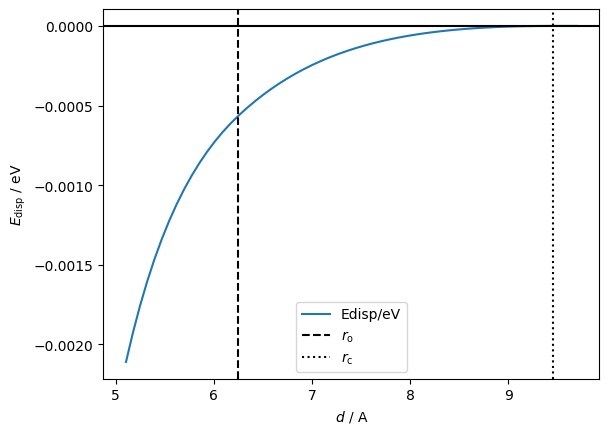

In [40]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_10.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
plt.axhline(y=0, color="black")
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

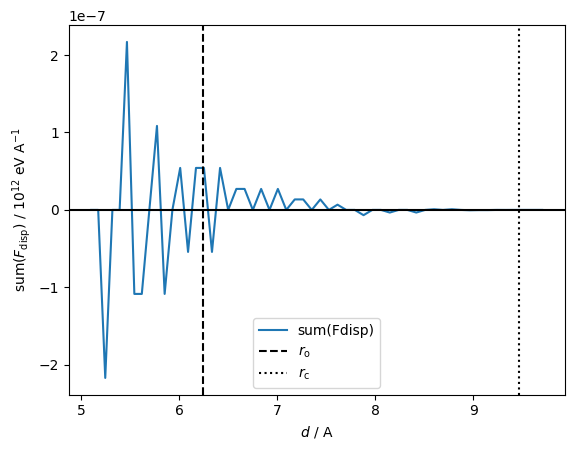

In [41]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_10.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
plt.axvline(x=6.2441, color="black", linestyle="--", label="$r_\mathrm{o}$")
plt.axvline(x=9.4607, color="black", linestyle=":", label="$r_\mathrm{c}$")
plt.axhline(y=0, color="black")
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / 10$^{12}$ eV A$^{-1}$")
plt.legend()
plt.show()

Finally, here are the full energy and force plot with PBCs enabled and $N_\mathrm{c} = [10,10,10]$ with one molecule being dragged away several cell lengths:

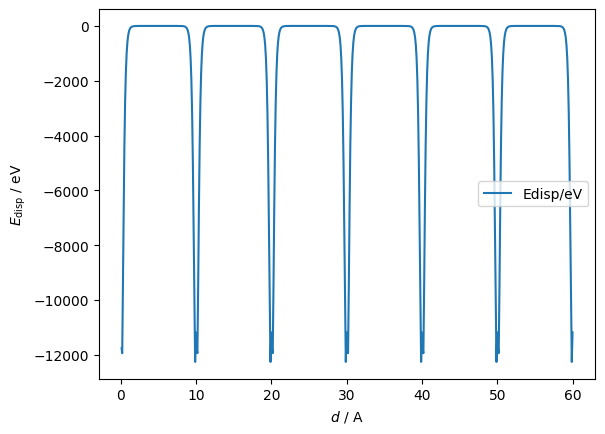

In [44]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_10_fullscale.dat", delim_whitespace=True)
df.plot(x="d/A", y="Edisp/eV", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("$E_\mathrm{disp}$ / eV")
plt.legend()
plt.show()

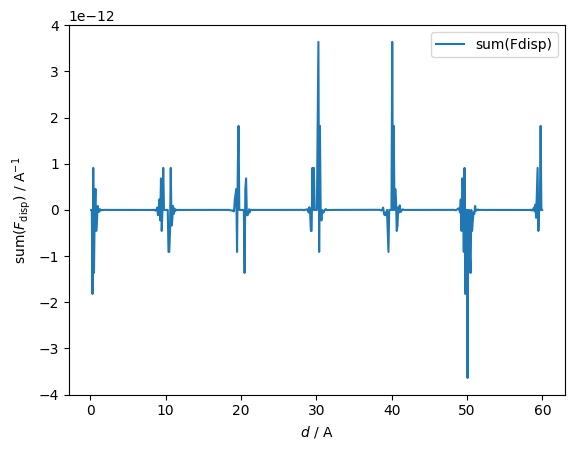

In [45]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_10_fullscale.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / A$^{-1}$")
plt.legend()
plt.show()

Note that the forces here are NOT rescaled as was done before, these are the absolute values. 

The results are peculiar, it is not immediately obvious why the forces do not look the same on every repetition like the energy results do. The fluctuations are close to but still within double point precision (15-16 digits).

The form of the force response is independent of $N_\mathrm{c}$ - tested until [50,50,50].

For comparison, here are the forces from commit [`49397911dbb02146a2f76b68285be68802c80971`](https://gitlab.com/AnoopANair/scmecpp/-/commit/49397911dbb02146a2f76b68285be68802c80971), which was after the PBC fix but before any further additions like the smooth cutoff or the $N_\mathrm{c}$ dependence:

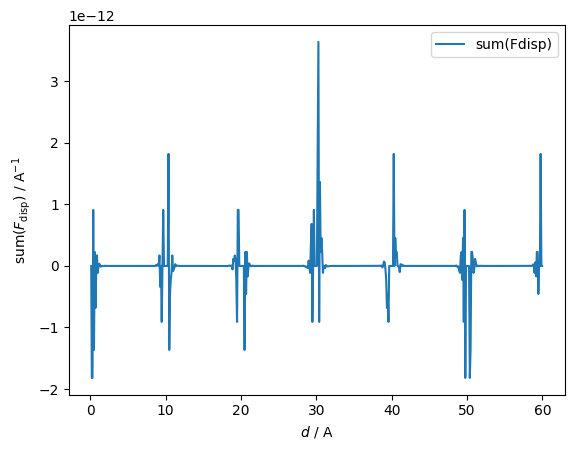

In [46]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_old_reference.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / A$^{-1}$")
plt.legend()
plt.show()

Here the forces also do not look exactly the same, but they look differently not the same as in the latest implementation.

Increasing the resolution by decreasing $\Delta d$ from 0.1 A to 0.01 A makes results look a little smoother

1) most recent implementation:

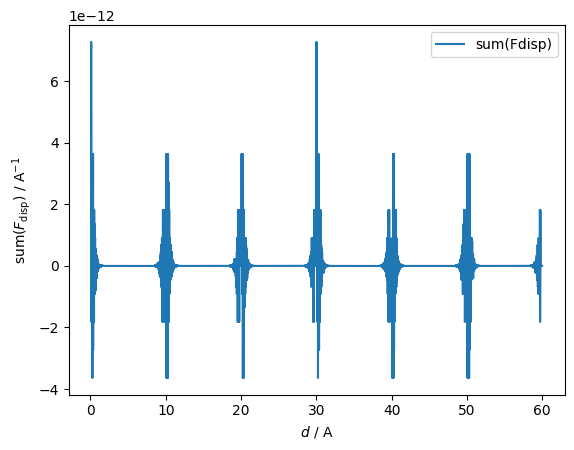

In [47]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_10_fullscale_highres.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / A$^{-1}$")
plt.legend()
plt.show()

2) old commit again:

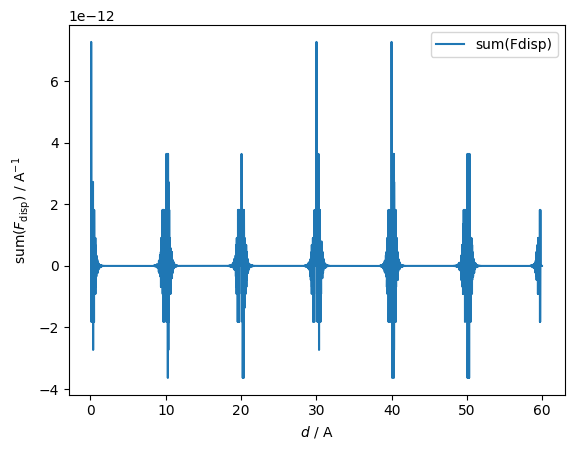

In [48]:
fig, ax = plt.subplots(1,1)
df = pd.read_csv("../data/20230412_2H2O_Nc_validation_pbc_true_Nc_old_reference_highres.dat", delim_whitespace=True)
df.plot(x="d/A", y="sum(Fdisp)", ax=ax)
ax.set_xlabel("$d$ / A")
ax.set_ylabel("sum$(F_\mathrm{disp})$ / A$^{-1}$")
plt.legend()
plt.show()

I find it hard to decide if this is an issue or not, need to discuss.

In our discussion of this implementation so far, we identified a couple of issues with this approach:

1) The code needs to take into account self-interaction of the same molecule with itself outside the original cell.

2) In a simple test arrangement of 2 molecules (MM, QM), the above code breaks since it checks that the second molecule cannot be QM. Instead, we need to check that both molecules are not QM at the same time but allow the second molecule to be QM as well.

3) At the same time we don't want double counting, *i.e.*, do not calculate the $(m,n)$ pair if the $(n,m)$ pair was already evaluated.

The thusly modified code now reads:

```C++
for (int nx = -Nc[0]; nx < Nc[0]+1; nx++) {
    for (int ny = -Nc[1]; ny < Nc[1]+1; ny++) {
        for (int nz = -Nc[2]; nz < Nc[2]+1; nz++) {
            int nArray [3] = {nx, ny, nz};
            // Loop through all water molecules.
            for (int n = 1; n < nM+1; n++) {
                // Find index of oxygen atom 1.
                iOn = 9*(n-1);
                // Loop through all water molecules again.
                for (int m = n; m < nM+1; m++) {
                    // Skip self-interaction in the original cell.
                    if (n == m && nx == 0 && ny == 0 && nz == 0) {
                        continue;
                    }
                    // Skip QM-QM interactions.
                    if (tags[n] && tags[m]) {
                        continue;
                    }
                    else {
                        // [do the actual calculations]
                    }
                }
            }
        }
    }
}
```

To make sure that the code is producing only those interactions that we need, we are writing out $n$, $m$, $nx$, $ny$, and $nz$ for a test system with 2 water molecules and `NC=[1,1,1]`:

```
nx = -1, ny = -1, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = -1, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = -1, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = 0, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = 0, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = 0, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = 1, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = 1, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = -1, ny = 1, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = -1, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = -1, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = -1, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = 0, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = 0, nz = 0
n = 1, m = 2

nx = 0, ny = 0, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = 1, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = 1, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 0, ny = 1, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = -1, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = -1, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = -1, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = 0, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = 0, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = 0, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = 1, nz = -1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = 1, nz = 0
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2

nx = 1, ny = 1, nz = 1
n = 1, m = 1
n = 1, m = 2
n = 2, m = 2
```

These results confirm that self-interaction ($n == m$) is accurately skipped for $nx == ny == nz == 0$ and taken into account otherwise, and that all required permutations are generated.